# Image Classifier

## Performing Pre-Processing and Sequential filtering on RGB Data for Topic Identification

### Summary: 

#### 1. Virtual Environment Set-Up
#### 2. Database Inspection
#### 3. Pipeline Building
##### 3.1 Engineering of a Lenet_like class
##### 3.2 Engineering of a Lenet_like model
#### 4. Model Fitting
#### 5. Cross-Validation
#### 6. Sensitivity Analysis

#### Mount the virtual environment on a Google Drive folder

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import and load packages from the keras library

In [2]:
import tensorflow
from keras.datasets import mnist, fashion_mnist, cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten, Input
from tensorflow.keras.utils import to_categorical
import numpy
import os
from tensorflow.keras.optimizers import SGD, Adam
from matplotlib import pyplot as plt

## Setup
Before you start, please mount your google drive.
For each exercise, create an output directory to store monitoring data and your model.

In [3]:
OUTDIR = "/content/drive/My Drive/Classification"
if not os.path.exists(OUTDIR):
  os.makedirs(OUTDIR)
# First, check dimensions of the datasets !
# shape of images in cifar10: (?, ?, ?)
# shape of images in mnist: (?, ?)
# shape of images in fashion_mnist: (?, ?)

In [4]:
# setting class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# defining training and testing sets

(x_train,y_train),(x_test,y_test)=cifar10.load_data()
x_train=x_train/1000.0
x_train.shape
x_test=x_test/1000.0
x_test.shape

170508288/170498071 [==============================] - 3s 0us/step


(10000, 32, 32, 3)

In [5]:
# defining training and testing sets

(x_train_2, y_train_2), (x_test_2, y_test_2) = tensorflow.keras.datasets.mnist.load_data()
x_train_2.shape

11501568/11490434 [==============================] - 0s 0us/step


(60000, 28, 28)

In [6]:
x_train.shape

(50000, 32, 32, 3)

In [7]:
x_test.shape

(10000, 32, 32, 3)

In [8]:
x_test.shape[3]

3

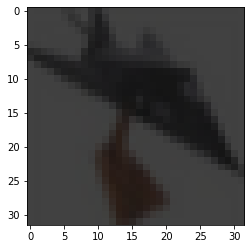

In [9]:
plt.imshow(x_test[215])

The dataset is defined as a four-dimensional vector (number_of_images, number_of_pixels_in_length, number_of_pixels_in_height, number_of_features_per_pixel)

Here the number of features per pixels equals 3 and translates into the value of R, G and B.

# EX1: Lenet-like classifier.

## 1- Build model architecture
The architecture has to be a CLASS called "Lenet_like".

- I can define the width: number of filters in the first layer.
- I can define the depth: number of conv layers.
- I can specify the number of classes: output neurons.

Lenet_like has no input tensor. But it has a \_\_call\_\_ function and can therefore be called on an input later.

The rule to go from depth d to depth d+1, is to reduce the spatial size by a factor of 2 in each direction.

Hidden dense layer will have 512 units.

We define a Lenet_like class with an __init__ function taking as inputs:
- self: the object 
- width: the number of filters in the first layer
- depth: the size of each kernels
- drop: the dropout rate
- n_classes: the number of classes in the dataset i.e. the ouptut dimension

Very simply speaking, we consider an image of 32x32 pixels, the goal of the Convolutional Neural Network is to simplify the image in order to extract its core features.

The extraction of core features results in the processing of the said-image through a *filter*.

Algebraically, such filter is defined by a matrix, called a *kernel*. In particular, filtering an image consists in pre-multiplying the matrix of pixels in their RGB encoding by the kernel of interest, and apply that application to a reduced sub-region of the image e.g. the central element. 

By doing this, one not only mutes undesired features of the image, but it exarcerbates the remaining features by applying them to entire batches of pixels. The matricial product i.e. convolution is in fact at the heart of the lexicology surrounding the Network's Theory.

Edge handling involved different methods to make the convolution possible when there is no physical pixels neighbouring the ones that are being filtered or convoluted by the kernel. 

One can extend the image with as many white pixels as necessary to create an artificial neighbouring of the pixels at the edge. 

Alternatively, one can also wrap the image in order to tie together pixels positioned at opposite edges of the image. 

Mirroring is another technique used, and assume that the image is symmetric. 

One can also discard pixels with no neighbours, by cropping the image, or even adding a constant for such edge-pixels. 


The size of the kernel is in fact the size of the window of neighbours applied to each pixel, the larger the window, the more difficult it is for each pixels to find enough neigbhours. It actually pulls edges towards the center of the image and calls for eventually unnecessary croping, mirroring or wrapping pre-processing. 
 

Empirics guiding the practionner often calls for an increasing number of filters at each layer of the network. Learning from a raw image needs a lot of processing whereas end-processing can benefits from more filters without using as much RAM and GPU space.



In [10]:
# first model
# Lenet-like
class Lenet_like:
  """
  Lenet like architecture.
  """
  def __init__(self, width, depth, drop, n_classes):
    """
    Architecture settings.

    Arguments:
      - width: int, first layer number of convolution filters.
      - depth: int, number of convolution layer in the network.
      - drop: float, dropout rate.
      - n_classes: int, number of classes in the dataset.
    """
    self.width = width
    self.depth = depth
    self.drop = drop
    self.n_classes = n_classes
  
  def __call__(self, X):
    """
    Call classifier layers on the inputs.
    """

    for k in range(self.depth):
      # Padding refers to the edge-handling techniques aforementioned . 
      # When the value of the parameter is set to "VALID", it means that there
      # is no padding of zeros on the boudary of the image i.e. loss of data.
      # The opposite happens when the value is set to "SAME".

      # First Layer (tensor collected raw data)

      Y = tensorflow.keras.layers.Conv2D(filters=self.width, kernel_size=self.depth, padding="same", activation="relu",
                                         input_shape=(32, 32, 3))(X)

      # Second Layer

      Y = tensorflow.keras.layers.Conv2D(filters=self.width, kernel_size=self.depth, padding="same", activation="relu")(Y)


      # First Max Pooling Layer

      Y = tensorflow.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid')(Y)

      # Third Layer

      Y = tensorflow.keras.layers.Conv2D(filters=self.width*2, kernel_size=self.depth, padding="same", activation="relu")(Y)

      # Fourth Layer
      Y = tensorflow.keras.layers.Conv2D(filters=self.width*2, kernel_size=self.depth, padding="same", activation="relu")(Y)

      # Second Max Pooling Layer
      Y = tensorflow.keras.layers.MaxPool2D(pool_size=2, strides=2, padding="valid")(Y)

      # Flattening Layer
      Y = tensorflow.keras.layers.Flatten()(Y)

      # Droput Layer
      Y = tensorflow.keras.layers.Dropout(self.drop, noise_shape=None, seed=None)(Y)


      # Adding the first fully connected layer
      Y = tensorflow.keras.layers.Dense(units=self.width*4, activation="relu")(Y)


      # Output Layer
      Y = tensorflow.keras.layers.Dense(units=self.n_classes, activation="softmax")(Y)

    return Y

## 2- A function to create a model with Lenet_like architecture
I want the model to be able to fit on the following datasets:

- mnist
- fashion-mnist
- cifar-10

Create a function called "make_lenet_model" that take the name of one of these dataset as a str.
It returns a keras Model object.
It should obviously take all arguments to init the Lenet_like architecture.
Arguments other than the dataset might have default values.
I want to be able to monitor the accuracy of the model.

In [11]:
def make_lenet_model(dataset,
                     width=32,
                     depth=2,
                     drop=0.25,
                     n_classes=1):
  """
  Create a Lenet model adapted to the dimensions of a given dataset.
  """
  if dataset == "cifar10":
    # dimensions of input are: (?, ?, ?)
    X = Input(batch_shape=(x_train.shape))
  elif dataset == "mnist" or dataset == "fashion_mnist":
    # dimensions of input are: (?, ?)
    X = Input(batch_shape=(x_train_2.shape))
  else:
    raise NotImplementedError("Model not implemented for datastet {}".format(dataset))
  
  Y = Lenet_like(width, depth, drop, n_classes)
  
  model = Y.__call__(x_train)
  # Remember I wanna monitor accuracy
  model.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=["sparse_categorical_accuracy"])
  return model

In [13]:
make_lenet_model("cifar10")

ResourceExhaustedError: ignored

## 3- Create a fitting function

I want a function "fit_model_on" with the following arguments:

- dataset: str name of the dataset
- epochs: number of times you fit on the entire training set
- batch_size: number of images to average gradient on

The function must create a Lenet model and fit it following these parameters.
The function should:

- fit the model, obviously
- store the model architecture in a .json file in your output directory
- store the model's weights in a .h5 file in your output directory
- store the fitting metrics loss, validation_loss, accuracy, validation_accuracy under the form of a plot exported in a png file.

Run your fitting function of course.

In [14]:
def fit_model_on(dataset,
                 epochs=100,
                 batch_size=32,
                 n_classes=10):
  
  model_filename = "lenet_{}.json".format(dataset)
  weight_filename = "lenet_{}_weights.h5".format(dataset)
  lossplot_filename = "lenet_{}_loss.png".format(dataset)
  accplot_filename = "lenet_{}_accuracy.png".format(dataset)
  
  # create your model and call it on your dataset
  model = ...
  # create a Keras ImageDataGenerator to handle your dataset
  datagen = ...
  
  if dataset == "cifar10":
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  elif dataset == "mnist":
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
  elif dataset == "fashion_mnist":
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
  else:
    raise NotImplementedError("Model not implemented for datastet {}".format(dataset))
  
  # Convert class vectors to binary class matrices (one-hot encoding).
  y_train = to_categorical(y_train, n_classes)
  y_test = to_categorical(y_test, n_classes)

  # Be sure that your training/test data is 'float32'
  x_train = ...
  x_test = ...
  # Be sure that your training/test data are between 0 and 1 (pixel image value)
  x_train ...
  x_test ...

  try:
    # Fit with keras using 'datagen', the previously defined image generator
    history = model.fit_generator(...)
  except KeyboardInterrupt:
    print("Training interrupted!")
  
  # first, save the model
  json_str = model.to_json()
  model_path = os.path.join(OUTDIR, model_filename)
  weight_path = os.path.join(OUTDIR, weight_filename)
  with open(model_path, "w") as txtfile:
    txtfile.write(json_str)
  
  # then, save the weights
  model.save_weights(weight_path)
  
  # finally, plot and save the metrics
  ...


SyntaxError: ignored

In [15]:
# fit your model
...

# EX2: Lenet-like auto-encoder.

This one is very hard, It is fine if you do not finish.
It's about autoencoders, feel free to read more about autoencoders : https://blog.keras.io/building-autoencoders-in-keras.html

Autoencoders are a very special kind of model. Input $x$ is an image, output $y$ is an image. The model is supposed to predict $x = y$ ! Usually, you build an autoencoder to create a 'deep' representation of your images : the model break your image into a high level descriptor that is useful to build your image back (the descriptors' space is supposed to be very powerful for clustering and image matching algorithms). The representation is built in an unsupervised way ; if $f$ is the function defined by your model, then you expect $f$ to be such as:
$$f(x) = y;$$
$$x = y$$
So you try to minimize $||f(x) - x||^2$ (mean squared error)

## 1- Build model architecture
The architecture has to be a CLASS called "Autoencoder".

Basically, an autoencoder has two parts:
- the Encoder $(conv2D-Maxpooling)\times n$
- the Decoder $(conv2D-Upsampling)\times n$


Autoencoder has no input tensor. But it has a \_\_call\_\_ function and can therefore be called on an input later.

------------------------------

For the Encoder:

The rule to go from depth d to depth d+1, is to reduce the spatial size by a factor of 2 in each direction.

------------------------------
For the Decoder:

The rule to go from depth d to depth d+1, is to increase the spatial size by a factor of 2 in each direction.


In [16]:
from keras.layers import BatchNormalization, UpSampling2D

In [17]:
OUTDIR = "/content/drive/My Drive/Autoencoding"
if not os.path.exists(OUTDIR):
  os.makedirs(OUTDIR)

In [18]:
# first model
# Lenet-like
class Autoencoder:
  """
  Aurtoencoder architecture.
  """
  def __init__(self):
    """
    Architecture settings.
    """
    # nothing to do in the init.
  
  def __call__(self, X):
    """
    Call autoencoder layers on the inputs.
    """

    # encode
    Y = ...
    Y = ...
    Y = ...
    # decode
    Y = ...
    Y = ...
    Y = ...

    return Y

## 2- A function to create a model with your Autoencoder architecture
I want the model to be able to fit on the following datasets:

- cifar-10

Create a function called "make_autoencoder_model" that take no argument.
It only returns a keras Model object.

In [19]:
def make_autoencoder_model():
  """
  Create and compile autoencoder keras model.
  """
  X = Input(batch_shape=(...))
  Y = Autoencoder()(X)
  model = Model(inputs=X, outputs=Y)
  model.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')
  return model

Useful function to plot the resulting image produced by your autoencoder.
Read them carefully if you want to plot your output correctly (especially 'comparison')

In [20]:
def stack_horizontally(min, max, images):
    return numpy.hstack(images[i] for i in range(min, max))

def stack_vertically(length, height, images):
    return numpy.vstack(stack_horizontally(i * length, (i + 1) * length, images) for i in range(height))

def comparison(inputimgs, outputimgs, length, height):
    A = stack_vertically(length, height, inputimgs)
    B = stack_vertically(length, height, outputimgs)
    C = numpy.ones((A.shape[0], 32, 3))
    return numpy.hstack((A, C, B))

## 3- Create a fitting function

I want a function "fit_model_cifar10" with the following arguments:

- dataset: str name of the dataset
- n_epochs: number of times you fit on the entire training set
- batch_size: number of images to average gradient on
- visualization_size (square root of number of test pred you wanna show to check your result)
- verbose (debug purpose to see tensor dimensions in your architecture)

The function must create an autoencoder model and fit it following these parameters.
The function should:

- fit the model, obviously
- store the model architecture in a .json file in your output directory
- store the model's weights in a .h5 file in your output directory
- store the fitting metrics loss, validation_loss, under the form of a plot exported in a png file.
- store the rebuilt test images under the form of a plot exported in a png file.

Run your fitting function of course.

In [ ]:
def fit_model_on_cifar10(n_epochs=3, batch_size=128, visualization_size=5, verbose=1):

  model_filename = "autoencoder_cifar10.json"
  weight_filename = "autoencoder_cifar10_weights.h5"
  lossplot_filename = "autoencoder_cifar10_loss.png"
  visuplot_filename = "autoencoder_cifar10_visu.png"
  # create your model and call it on your dataset
  model = ...
  if verbose > 0:
    print(model.summary())
  (x_train, _), (x_test, _) = cifar10.load_data()
  # Be sure that your training/test data is 'float32'
  x_train = ...
  x_test = ...
  # Be sure that your training/test data are between 0 and 1 (pixel image value)
  x_train ...
  x_test ...
  try:
    history = model.fit(...)
  except KeyboardInterrupt:
    print("Training interrupted!")
  
  # first, save the model
  json_str = model.to_json()
  model_path = os.path.join(OUTDIR, model_filename)
  weight_path = os.path.join(OUTDIR, weight_filename)
  with open(model_path, "w") as txtfile:
    txtfile.write(json_str)
  # then, save the weights
  model.save_weights(weight_path)
  # now, save metrics plots
  ...

In [ ]:
# fit your model
...